# multiclass classifier evaluation #

A bit tongue twist to read, perhaps call it multi label classifier or multi target classifier.. anywhoo, like multi class classifier. Fun

Here comes some thoughts on evaluate 'em

1. confusion matrix, good old friend
2. cross entropy
3. micro vs. macro F1
4. ROC .. yes, you hear it.. one-vs-rest still function, be cautious though.. and for three class, there is an 3D version of it. 4D for four class, other than tongue twist, brain twist is required
5. Lift, Gain?
6. Calibration, K-S ?

P.S. None of these would not make sense, if not for model comparison purpose, be it comparing to the hypothetical 50-50 draw or an baseline regression model.

In [419]:
library(reticulate)
use_python('/PYTHON_SERVICES')

In [391]:
torch = import("torch")
nn    = import("torch.nn")

In [408]:
m = nn$Sequential( nn$Linear(4L, 13L), 
                  nn$ReLU(),
                  nn$Linear(13L, 3L),
                  nn$Softmax()
                 )

In [409]:
m

Sequential(
  (0): Linear(in_features=4, out_features=13, bias=True)
  (1): ReLU()
  (2): Linear(in_features=13, out_features=3, bias=True)
  (3): Softmax()
)

In [394]:
idx <- sample(1:nrow(iris), 30)
train <- iris[-idx, ]
test <- iris[idx,]
# new.data <- matrix(scale(test[,1:4]), nrow=20, ncol=4)


In [395]:
x_train <- torch$from_numpy(as.matrix(iris[-idx, 1:4]))$float()
x_val   <- torch$from_numpy(as.matrix(iris[ idx, 1:4]))$float()
x_train$size()
x_val$size()

torch.Size([120, 4])

torch.Size([30, 4])

In [396]:
y_train <- torch$from_numpy(as.matrix(as.integer(iris[-idx,5])-1))$long()
y_train <- torch$squeeze(y_train, 1L)
y_val   <- torch$from_numpy(as.matrix(as.integer(iris[idx,5])-1))$long()
y_val   <- torch$squeeze(y_val, 1L)

In [397]:
y_train$size()
y_val$size()

torch.Size([120])

torch.Size([30])

In [398]:
main <- py_run_string("
def init_weight(m):
    #print m.__class__.__name__
    if isinstance(m, nn.Linear):
        #nn.init.normal_(m.weight.data, 1.0, 0.02)
        #nn.init.constant_(m.bias.data, 0)
        m.reset_parameters()
        #print m.weight.data, m.bias.data
")

In [410]:
m$apply(main$init_weight)

Sequential(
  (0): Linear(in_features=4, out_features=13, bias=True)
  (1): ReLU()
  (2): Linear(in_features=13, out_features=3, bias=True)
  (3): Softmax()
)

In [411]:


EPOCH = 500
losses = matrix(0, nrow=EPOCH, ncol=2)

optim    <- torch$optim$Adam(m$parameters(), lr=.001)

for( e in 1:EPOCH)
{
        m$train()
        optim$zero_grad()
        yhat = m(x_train)
        # print(yhat)
        #l = nn$MSELoss()(yhat, y$float())
        l = nn$CrossEntropyLoss()(yhat, y_train)
        losses[e, 1] = l$item()
        l$backward()
        optim$step()

        #torch$no_grad() 
        #torch$set_grad_enabled(F)
        m$eval()
        pred = m(x_val)
        ll = nn$CrossEntropyLoss()(pred, y_val)
        losses[e,2] = ll$item()

}

In [412]:
summary(losses)

       V1               V2        
 Min.   :0.7479   Min.   :0.8092  
 1st Qu.:0.8064   1st Qu.:0.8901  
 Median :0.8761   Median :0.9896  
 Mean   :0.9054   Mean   :0.9851  
 3rd Qu.:1.0110   3rd Qu.:1.0889  
 Max.   :1.1294   Max.   :1.1538  

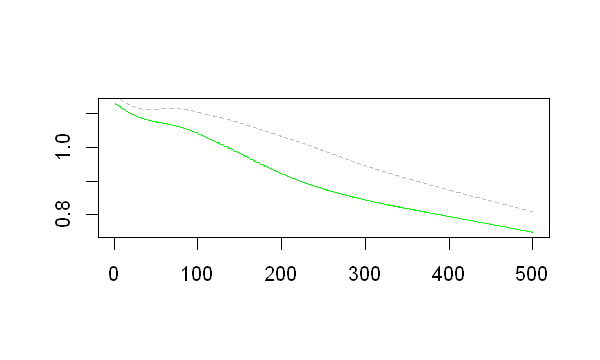

In [413]:
options(repr.plot.width = 5, repr.plot.height = 3)
plot(losses[,1], type="l", col="green", xlab="", ylab="")
lines(losses[,2], col="grey", type="l", lty=2)

In [414]:
m$eval()

Sequential(
  (0): Linear(in_features=4, out_features=13, bias=True)
  (1): ReLU()
  (2): Linear(in_features=13, out_features=3, bias=True)
  (3): Softmax()
)

In [415]:
p_train <- m(x_train)
p_val   <- m(x_val)

In [416]:
pred_class_train <- torch$max(p_train$data, 1L)
pred_class_val   <- torch$max(p_val$data, 1L)

In [417]:
table(pred_class_train[[2]]$numpy(), y_train$numpy())

   
     0  1  2
  0 41  0  0
  1  0 28  0
  2  0  8 43

In [418]:
table(pred_class_val[[2]]$numpy(), y_val$numpy())

   
     0  1  2
  0  9  0  0
  1  0 10  0
  2  0  4  7